In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augumentation

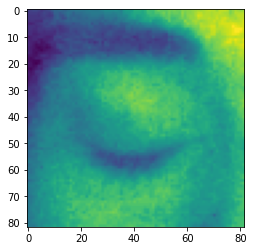

In [2]:
plt.imshow(plt.imread(r'P:/prml_project/drowsieness_detection/data/test/closed/s0001_00007_0_0_0_0_0_01.png'))

In [3]:
image = plt.imread(r'P:/prml_project/drowsieness_detection/data/test/closed/s0001_00007_0_0_0_0_0_01.png')

image.shape

(82, 82)

The Pre-trained model is trained on (224,224) so, we are changing shape of all images.

In [5]:
image_row = 224
image_col = 224

batch_Size = 8

In [6]:
#  Data Preprocessing

# Preprocessing the Training set  
        
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.2)  #validation_data = 20%

test_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(r'P:/prml_project/drowsieness_detection/data/train',
                                                 target_size = (image_row, image_col),
                                                 batch_size = batch_Size,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                 subset = 'training')

valid_data = train_datagen.flow_from_directory(r'P:/prml_project/drowsieness_detection/data/train',
                                                 target_size = (image_row, image_col),
                                                 batch_size = batch_Size,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                 subset = 'validation')

test_data = test_datagen.flow_from_directory(r'P:/prml_project/drowsieness_detection/data/test',
                                            target_size = (image_row, image_col),
                                            batch_size = batch_Size,
                                            shuffle = False,
                                            class_mode = None)
print(train_data.class_indices)


Found 54336 images belonging to 2 classes.
Found 13583 images belonging to 2 classes.
Found 16979 images belonging to 2 classes.
{'closed': 0, 'open': 1}


## Mobilenet Model Training

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D

In [8]:
#basemodel = MobileNet(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)))
basemodel = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [9]:
# don't train existing weights
for layer in basemodel.layers:
  layer.trainable = False

In [42]:
headmodel = basemodel.output
#headmodel = Flatten()(headmodel)
#headmodel = Dense(128, activation='relu')(headmodel)

#headmodel = Dense(8, activation='relu')(headmodel)
#headmodel = Dropout(0.7)(headmodel)

#headmodel = Dense(2,activation= 'softmax')(headmodel)

#headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headmodel=Flatten(name='Flatten')(headmodel)
headmodel=Dense(128,activation='relu')(headmodel)
headmodel=Dropout(0.5)(headmodel)
headmodel=Dense(2,activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs= headmodel)

# view the structure of the model
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(r'P:/prml_project/drosieness_detction/new_drowsi_model.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=valid_data.n//valid_data.batch_size
history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_data,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks,
                    epochs=5
)

Epoch 1/5
6792/6792 [==============================] - 1253s 184ms/step - loss: 0.2010 - accuracy: 0.9232 - val_loss: 0.2512 - val_accuracy: 0.8998

Epoch 00001: val_loss improved from inf to 0.25119, saving model to P:/prml_project/drosieness_detction\new_drowsi_model.h5
Epoch 2/5
6792/6792 [==============================] - 750s 110ms/step - loss: 0.1326 - accuracy: 0.9498 - val_loss: 0.2418 - val_accuracy: 0.9050

Epoch 00002: val_loss improved from 0.25119 to 0.24183, saving model to P:/prml_project/drosieness_detction\new_drowsi_model.h5
Epoch 3/5
6792/6792 [==============================] - 736s 108ms/step - loss: 0.1228 - accuracy: 0.9549 - val_loss: 0.2584 - val_accuracy: 0.9090

Epoch 00003: val_loss did not improve from 0.24183
Epoch 4/5
6792/6792 [==============================] - 747s 110ms/step - loss: 0.1144 - accuracy: 0.9568 - val_loss: 0.2507 - val_accuracy: 0.9067

Epoch 00004: val_loss did not improve from 0.24183
Epoch 5/5
6792/6792 [==============================] 

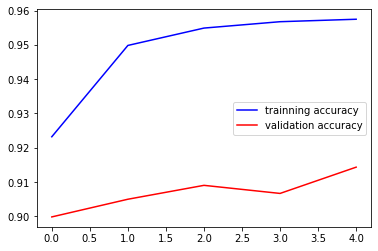

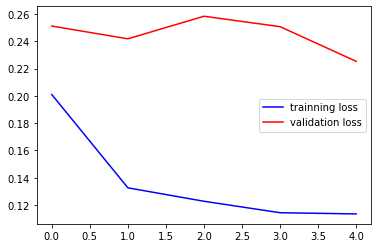

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [54]:
from tensorflow.keras.models import load_model

In [55]:
model.save('new_drowsi_model.h5')

# load model
model = load_model('drowsiness_detection_basemodel2.h5')


In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 84, 84, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          1

In [57]:
import numpy as np

STEP_SIZE_TEST=test_data.n//test_data.batch_size+1
test_data.reset()
y_pred=model.predict_generator(test_data,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class=np.argmax(y_pred,axis=1)
print(predicted_class)

2123/2123 [==============================] - 34s 16ms/step
[1 0 0 ... 1 0 0]


In [32]:
#Confusion Matrix and Classification Report
import sklearn.metrics as metrics


true_class = test_data.classes
#true_class = tf.concat([y for y in test_data.classes], axis=0)
print(true_class.shape)
print(predicted_class.shape)

print(true_class)
class_labels = list(test_data.class_indices.keys())  
print(class_labels)

print('Confusion Matrix')
cm = metrics.confusion_matrix(true_class, predicted_class)
print(cm)

print('Classification Report')
cr = metrics.classification_report(true_class, predicted_class, target_names=class_labels)
print(cr)

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

accuracy(cm)

(16979,)
(271664,)
tf.Tensor([0 0 0 ... 1 1 1], shape=(16979,), dtype=int32)
['closed', 'open']
Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [16979, 271664]

In [58]:
import cv2

img_array = cv2.imread(r'P:/prml_project/drowsieness_detection/data/test/open/s0037_09363_1_1_1_0_1_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
new_array = cv2.resize(backtorgb, (224, 224))
X_input = np.array(new_array).reshape(1, 224, 224, 3)
X_input.shape

(1, 224, 224, 3)

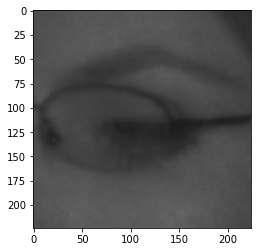

In [59]:
plt.imshow(new_array)

In [60]:
X_input = X_input/255.0
prediction = model.predict(X_input)

ValueError: in user code:

    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\functional.py:421 call
        inputs, training=training, mask=mask)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    p:\conda\envs\PRML\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 288 but received input with shape (None, 4608)


In [ ]:
np.argmax(prediction)